<a href="https://colab.research.google.com/github/abiget/YOLOv5-Transfer-Learning-Object-Detection/blob/main/YOLO_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cats Vs Dogs classification using YOLOv5 transfer learning model** 

In [30]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%pwd

'/content/drive/My Drive/yolov5-transfer-learning'

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%mdir yolov5-transfer-learning
%cd yolov5-transfer-learning

/content/drive/MyDrive/yolov5-transfer-learning


In [ ]:
%pwd

'/content/drive/MyDrive/yolov5-transfer-learning'

In [ ]:
#include openimages to download catsvsdogs dataset
import openimages

In [ ]:
!oi_download_dataset --base_dir download --csv_dir download --labels Cat Dog --format darknet --limit 500

In [32]:
from PIL import Image, ImageDraw
#Show sample image with its bounding box drown
def show_bbox(image_path):
  #convert image path to label path
  label_path = image_path.replace('/images', '/darknet')
  label_path = label_path.replace('.jpg', '.txt')

  #open image and create ImageDraw object
  image = Image.open(image_path)
  draw = ImageDraw.Draw(image)

  with open(label_path, 'r') as f:
    for file in f.readlines():
      label, x, y, w, h = file.split(" ")

      #convert string into float
      x = float(x)
      y = float(y)
      w = float(w)
      h = float(h)

      W, H = image.size
      x1 = (x - w/2)*W
      y1 = (y - h/2)*H
      x2 = (x + w/2)*W
      y2 = (y + h/2)*H

      #draw the bounding box with yellow line
      draw.rectangle((x1, y1, x2, y2),
                     outline=(255, 225, 0),
                     width=5)
  print(label)
  image.show("name")

In [41]:
# show_bbox("/content/drive/MyDrive/yolov5-transfer-learning/download/cat/images/0008ab3d8674f6ca.jpg")

In [33]:
import os
#create the directory structure that meets the yolov5 dataset directory structure
if not os.path.exists('data'):
  for folder in ['images', 'labels']:
    for split in ['train', 'val', 'test']:
      os.makedirs(f'data/{folder}/{split}')

In [34]:
import glob

#function collect filenames into set 
def get_filenames(folder):
  filenames = set()
  for path in glob.glob(os.path.join(folder, '*.jpg')):
    filename = os.path.split(path)[-1]
    filenames.add(filename)
  return filenames

In [ ]:
#collect filenames of dogs and cats
dog_images = get_filenames('download/dog/images')
cat_images = get_filenames('download/cat/images')

In [ ]:
#duplicate filenames occur in both 'dogs' and 'cats' folders
duplicates = cat_images & dog_images

In [ ]:
print(duplicates)

{'0838125199f2caa7.jpg', '0dcd8cc4b35a93b4.jpg', '1417eccd5854e04a.jpg'}


In [ ]:
from PIL import Image
# plot each duplicated image with thier full to the file names
for file in duplicates:
  for animal in ['cat', 'dog']:
    if os.path.exists(f'download/{animal}/images/{file}'):
      Image.open(f'download/{animal}/images/{file}').show()
      print(f'download/{animal}/images/{file}')

In [ ]:
#three files of cats are in dogs so removed
dog_images -= duplicates
print(len(dog_images))

497


In [ ]:
import numpy as np
dog_images = np.array(list(dog_images))
cat_images = np.array(list(cat_images))

#Use the same seed for repeatablity 
#shuffle the dogs and cats filenames 
np.random.seed(42)
np.random.shuffle(dog_images)
np.random.shuffle(cat_images)

In [ ]:
import shutil

def split_dataset(animal, image_names, train_size, val_size):
  for i, image_name in enumerate(image_names):
    #label filenames
    image_label = image_name.replace('.jpg', '.txt')
    # split into train, val or test
    if i < train_size:
      split = 'train'
    elif i < train_size + val_size:
      split = 'val'
    else:
      split = 'test'
    
    # source path
    src_image_path = f'download/{animal}/images/{image_name}' 
    src_label_path = f'download/{animal}/darknet/{image_label}'

    # destination path
    des_image_path = f'data/images/{split}/{image_name}'
    des_label_path = f'data/labels/{split}/{image_label}'

    #Copy files
    shutil.copy(src_image_path, des_image_path)
    shutil.copy(src_label_path, des_label_path)

# Cat data 
split_dataset('cat', cat_images, train_size=400, val_size=50)

#Dog data 
split_dataset('dog', dog_images, train_size=399, val_size=49)

In [ ]:
#Collcet image and text files from train, val, and test directories
train_path = 'data/images/train'
val_path = 'data/images/val'
test_path ='data/images/test'


def get_file_list(path, extension, file_type):
  file_list = []
  if file_type == 'labels':
    path = path.replace('images', 'labels')

  for image in glob.glob(os.path.join(path, f'*.{extension}')):
    file_list.append(image)
  return file_list  

file_type = 'images'
file_extension = 'jpg'
train_images = get_file_list(train_path, file_extension, file_type)
val_images = get_file_list(val_path, file_extension, file_type)
test_images = get_file_list(test_path, file_extension, file_type)

file_type = 'labels'
file_extension = 'txt'
train_txt = get_file_list(train_path, file_extension, file_type)
val_txt = get_file_list(val_path, file_extension, file_type)
test_txt = get_file_list(test_path, file_extension, file_type)

In [ ]:
os.path.splitext(os.path.basename('data/images/train/09cb9b384c6d7d80.jpg'))[0]

'09cb9b384c6d7d80'

In [ ]:
def check_match(list_type, images, texts):
  print(f'{list_type}_size_img_txt: {len(images), len(texts)}')
  print('Images check starting...')
  text_filenames = [os.path.splitext(os.path.basename(txt))[0] for txt in texts]
  for img in images:
    if os.path.splitext(os.path.basename(img))[0] not in text_filenames:
      print(img)
      print()
      print('-------------------------')

  print('Texts check starting...')
  image_filenames = [os.path.splitext(os.path.basename(img))[0] for img in images]
  for txt in texts:
    if os.path.splitext(os.path.basename(txt))[0] not in image_filenames:
      print(txt)
      print()
      print('--------------------------') 

In [ ]:
check_match('train', train_images, train_txt)

train_size_img_txt: (799, 799)
Images check starting...
Texts check starting...


In [ ]:
check_match('val', val_images, val_txt)

val_size_img_txt: (99, 99)
Images check starting...
Texts check starting...


In [ ]:
check_match('test', test_images, test_txt)

test_size_img_txt: (99, 99)
Images check starting...
Texts check starting...


In [ ]:
# # Create and activate a Python environment using venv for local machine
# !python3 -m venv venv
# !source venv/bin/activate

# # We should always upgrade pip as it's usually old version
# # that has older information about libraries
# !pip install --upgrade pip

In [ ]:
#clone the yolov5 from ultralytics github repo
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [35]:
#install dependencies of yolov5 
!pip install -U -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Train with the specified command**
* yolov5/train.py: the file where the training module located.
* --data : yaml configeration for the custom dataset.
* --weight: the pretrained weights as a starting point.
* --epochs: the number of pass through the training data. 
* --batch: batch size. 
* --freeze: the first number layers we take the weight as it's so beyond the layers will be affected by the custom data 
* --project: directory for restuls
* --name : folder containing restults
* --cache: use caching for faster training

In [ ]:
#Train
!python yolov5/train.py --data cats_and_dogs.yaml --weights yolov5s.pt --epochs 100 --batch 32 --cache --freeze 10 --project 'run_cat_vs_dogs' --name 'feature_extraction2'

train: weights=yolov5s.pt, cfg=, data=cats_and_dogs.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=run_cat_vs_dogs, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 1), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 4.62 KiB | 107.00 KiB/s, done.
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla

In [ ]:
#Validation
!python yolov5/val.py --data cats_and_dogs.yaml --weights run_cat_vs_dogs/feature_extraction2/weights/best.pt --project run_cat_vs_dogs --name validation

val: data=cats_and_dogs.yaml, weights=['run_cat_vs_dogs/feature_extraction2//weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=run_cat_vs_dogs, name=validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/drive/MyDrive/yolov5-transfer-learning/data/labels/val.cache... 99 images, 0 backgrounds, 0 corrupt: 100% 99/99 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:07<00:00,  1.81s/it]
                   all         99        118      0.762      0.879      0.862      0.668
                   cat         99         60      0.879      

In [42]:
val_result_path = 'run_cat_vs_dogs/validation/'

def show_result_images(path, file_extension):
  for file in glob.glob(os.path.join(path, f'*{file_extension}')):
    Image.open(file).show()
    break
  print("End...")
     

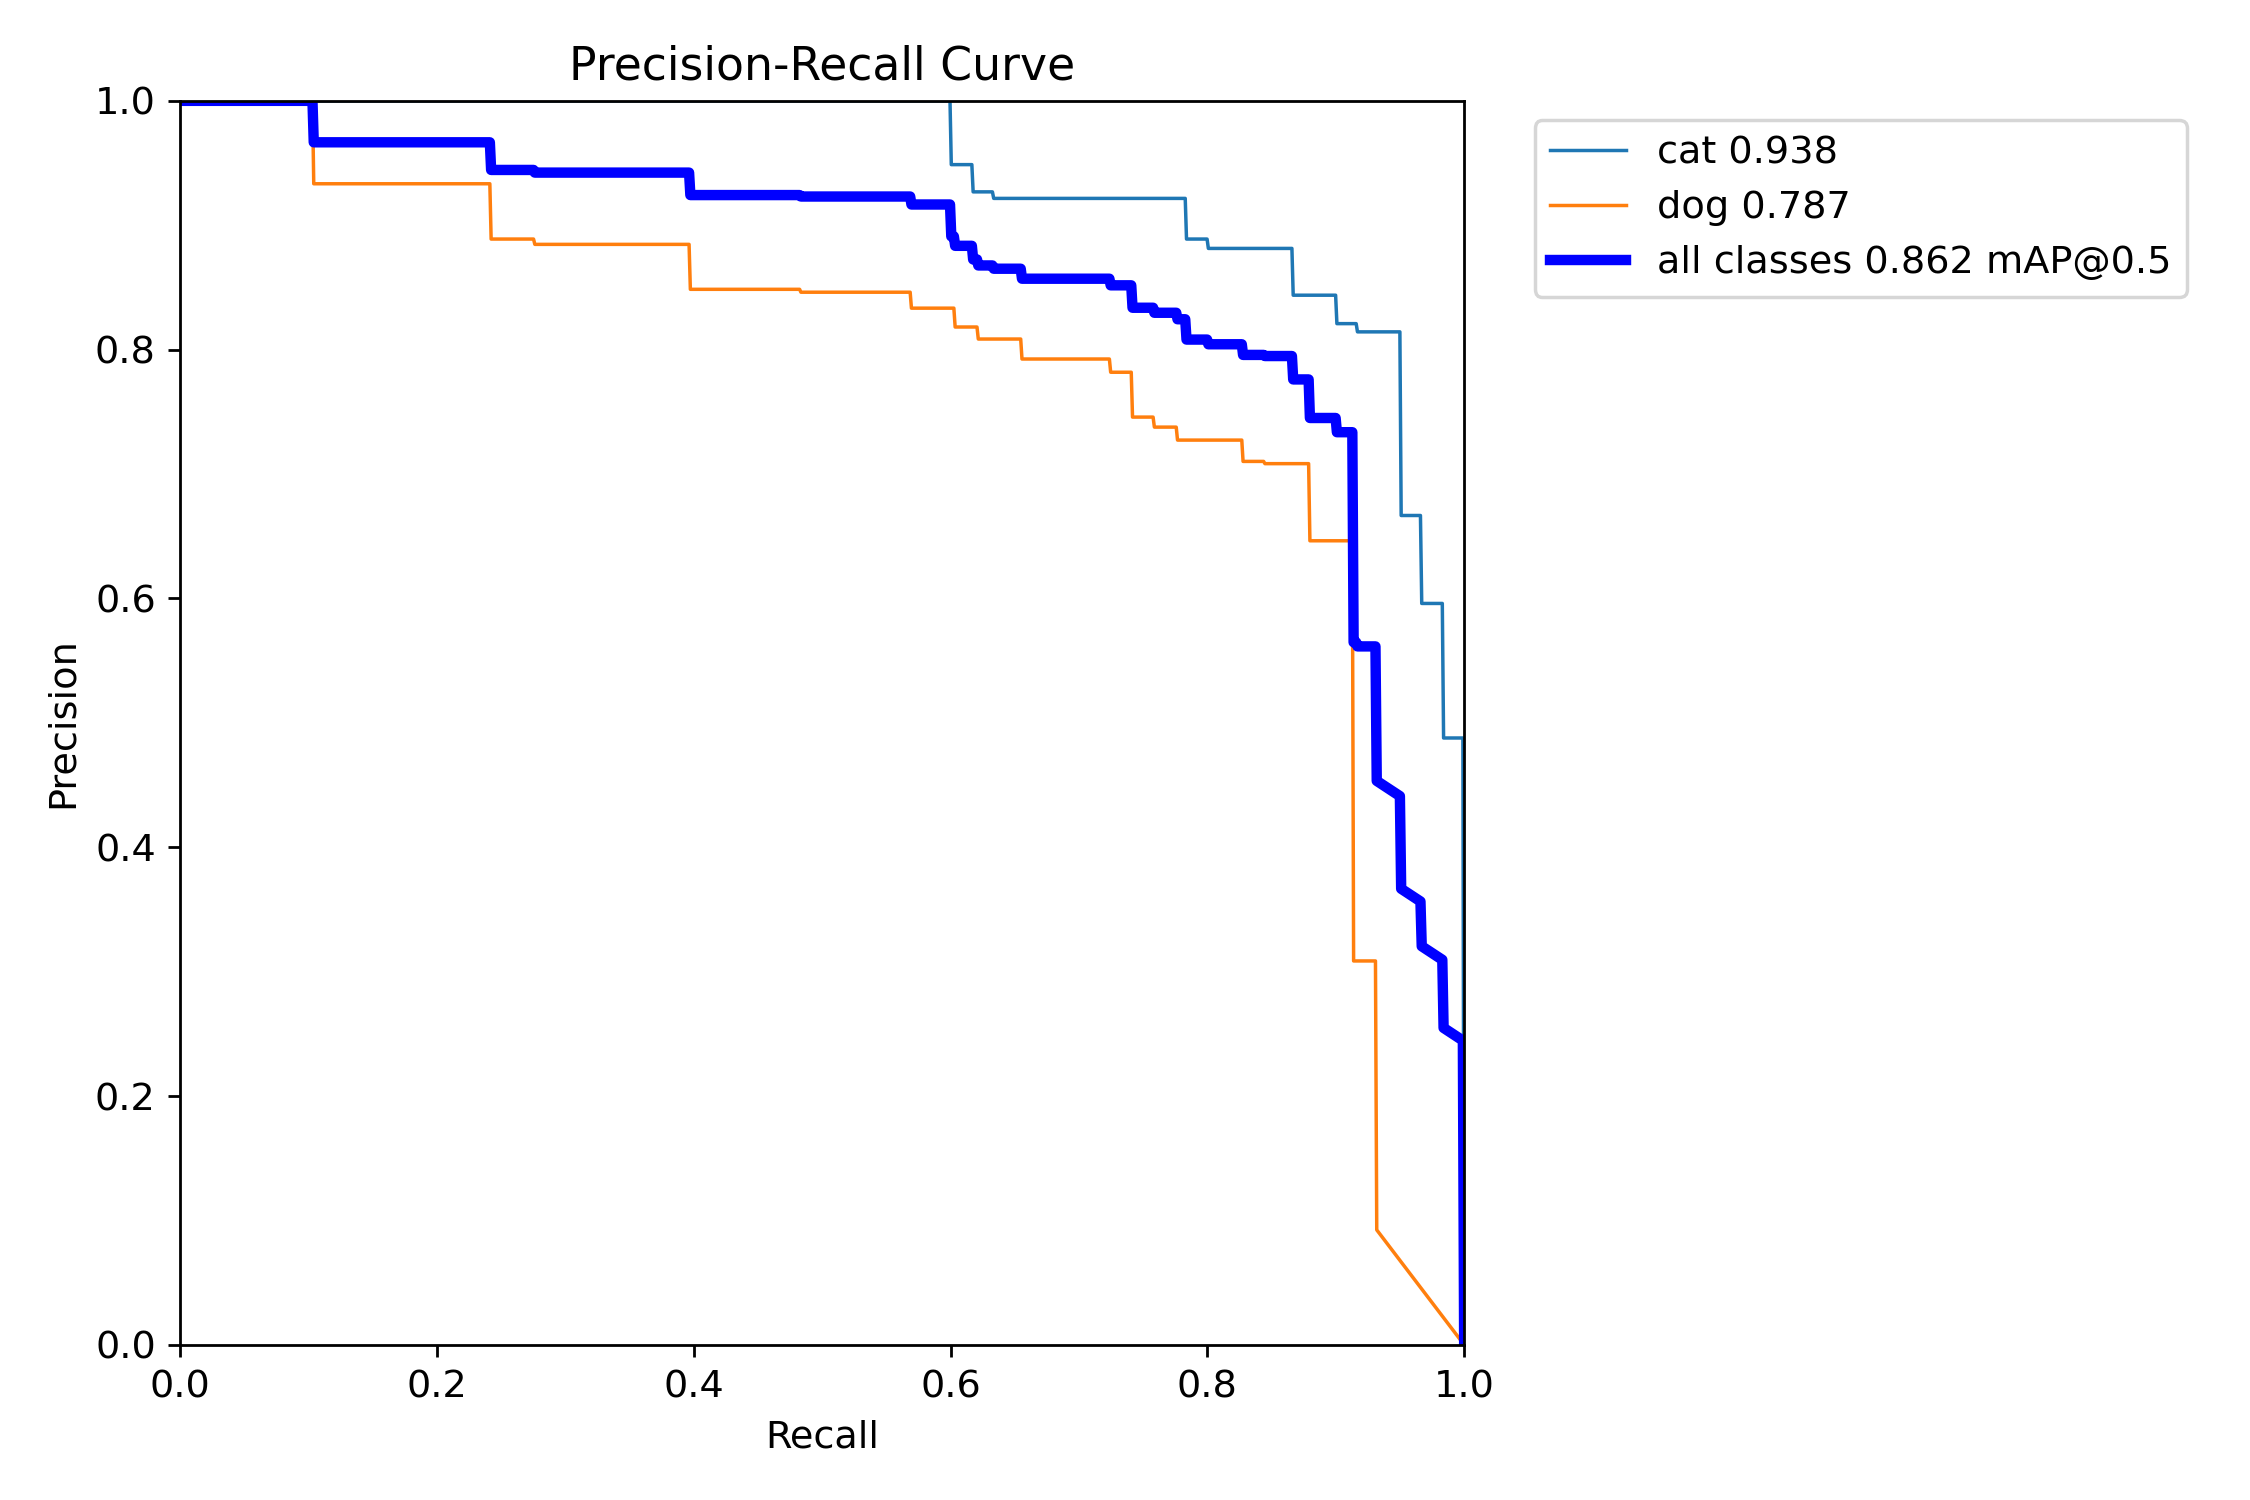

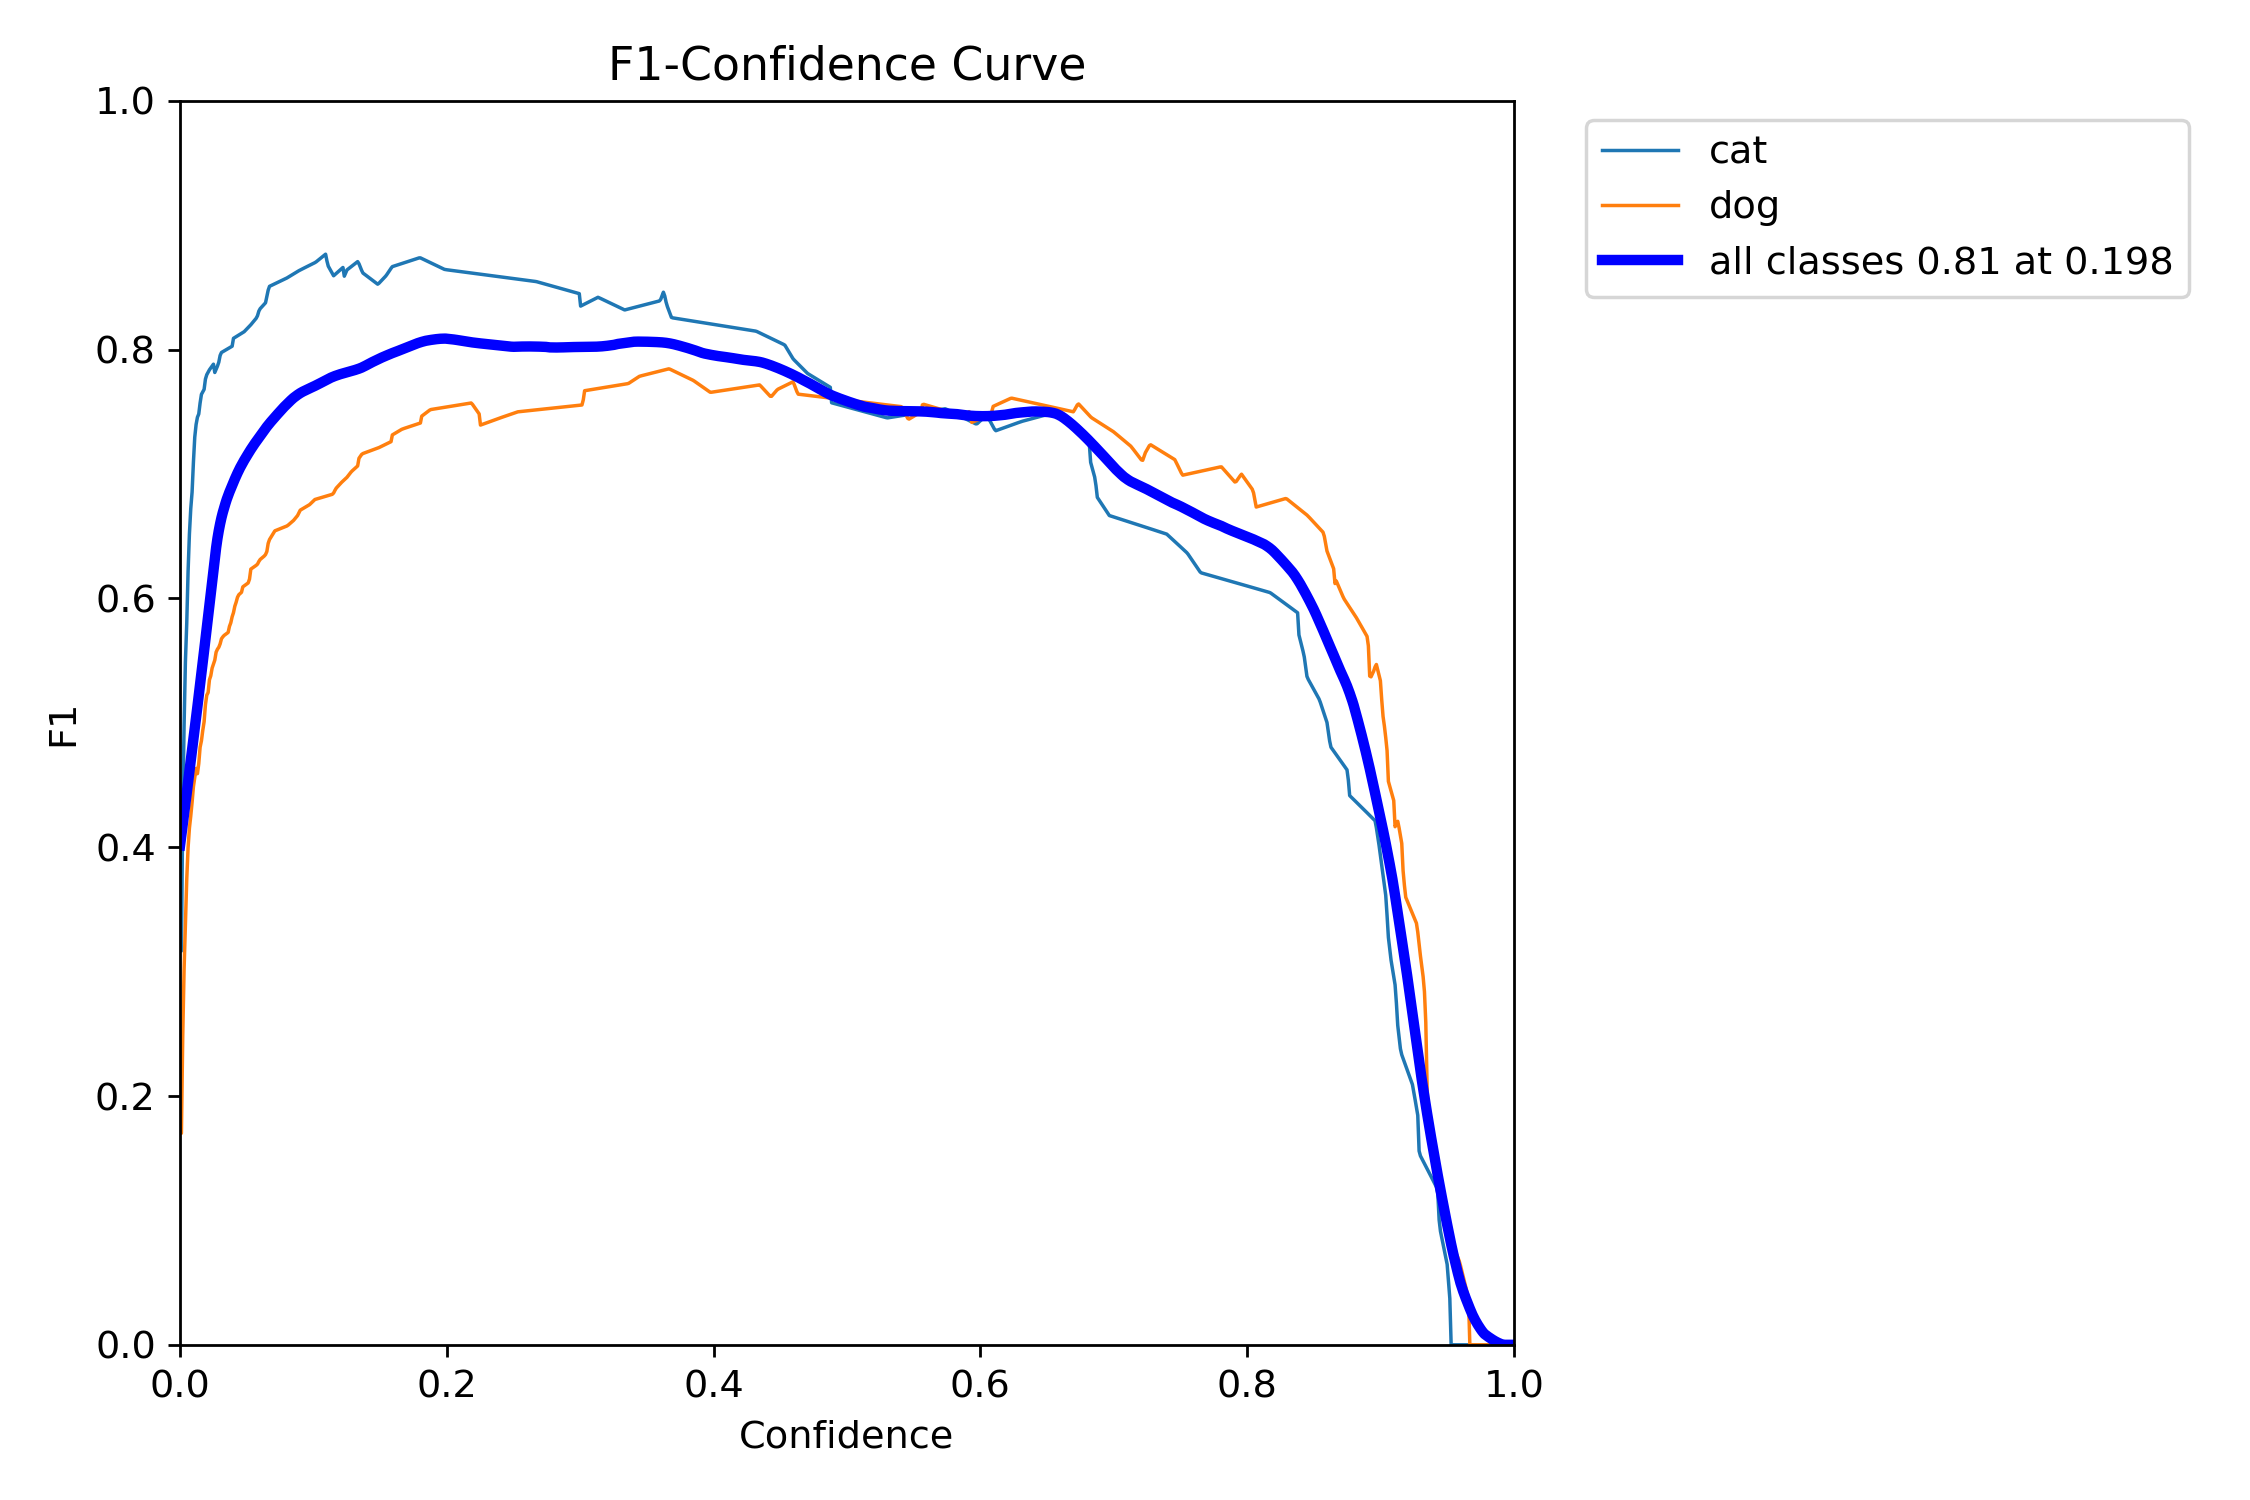

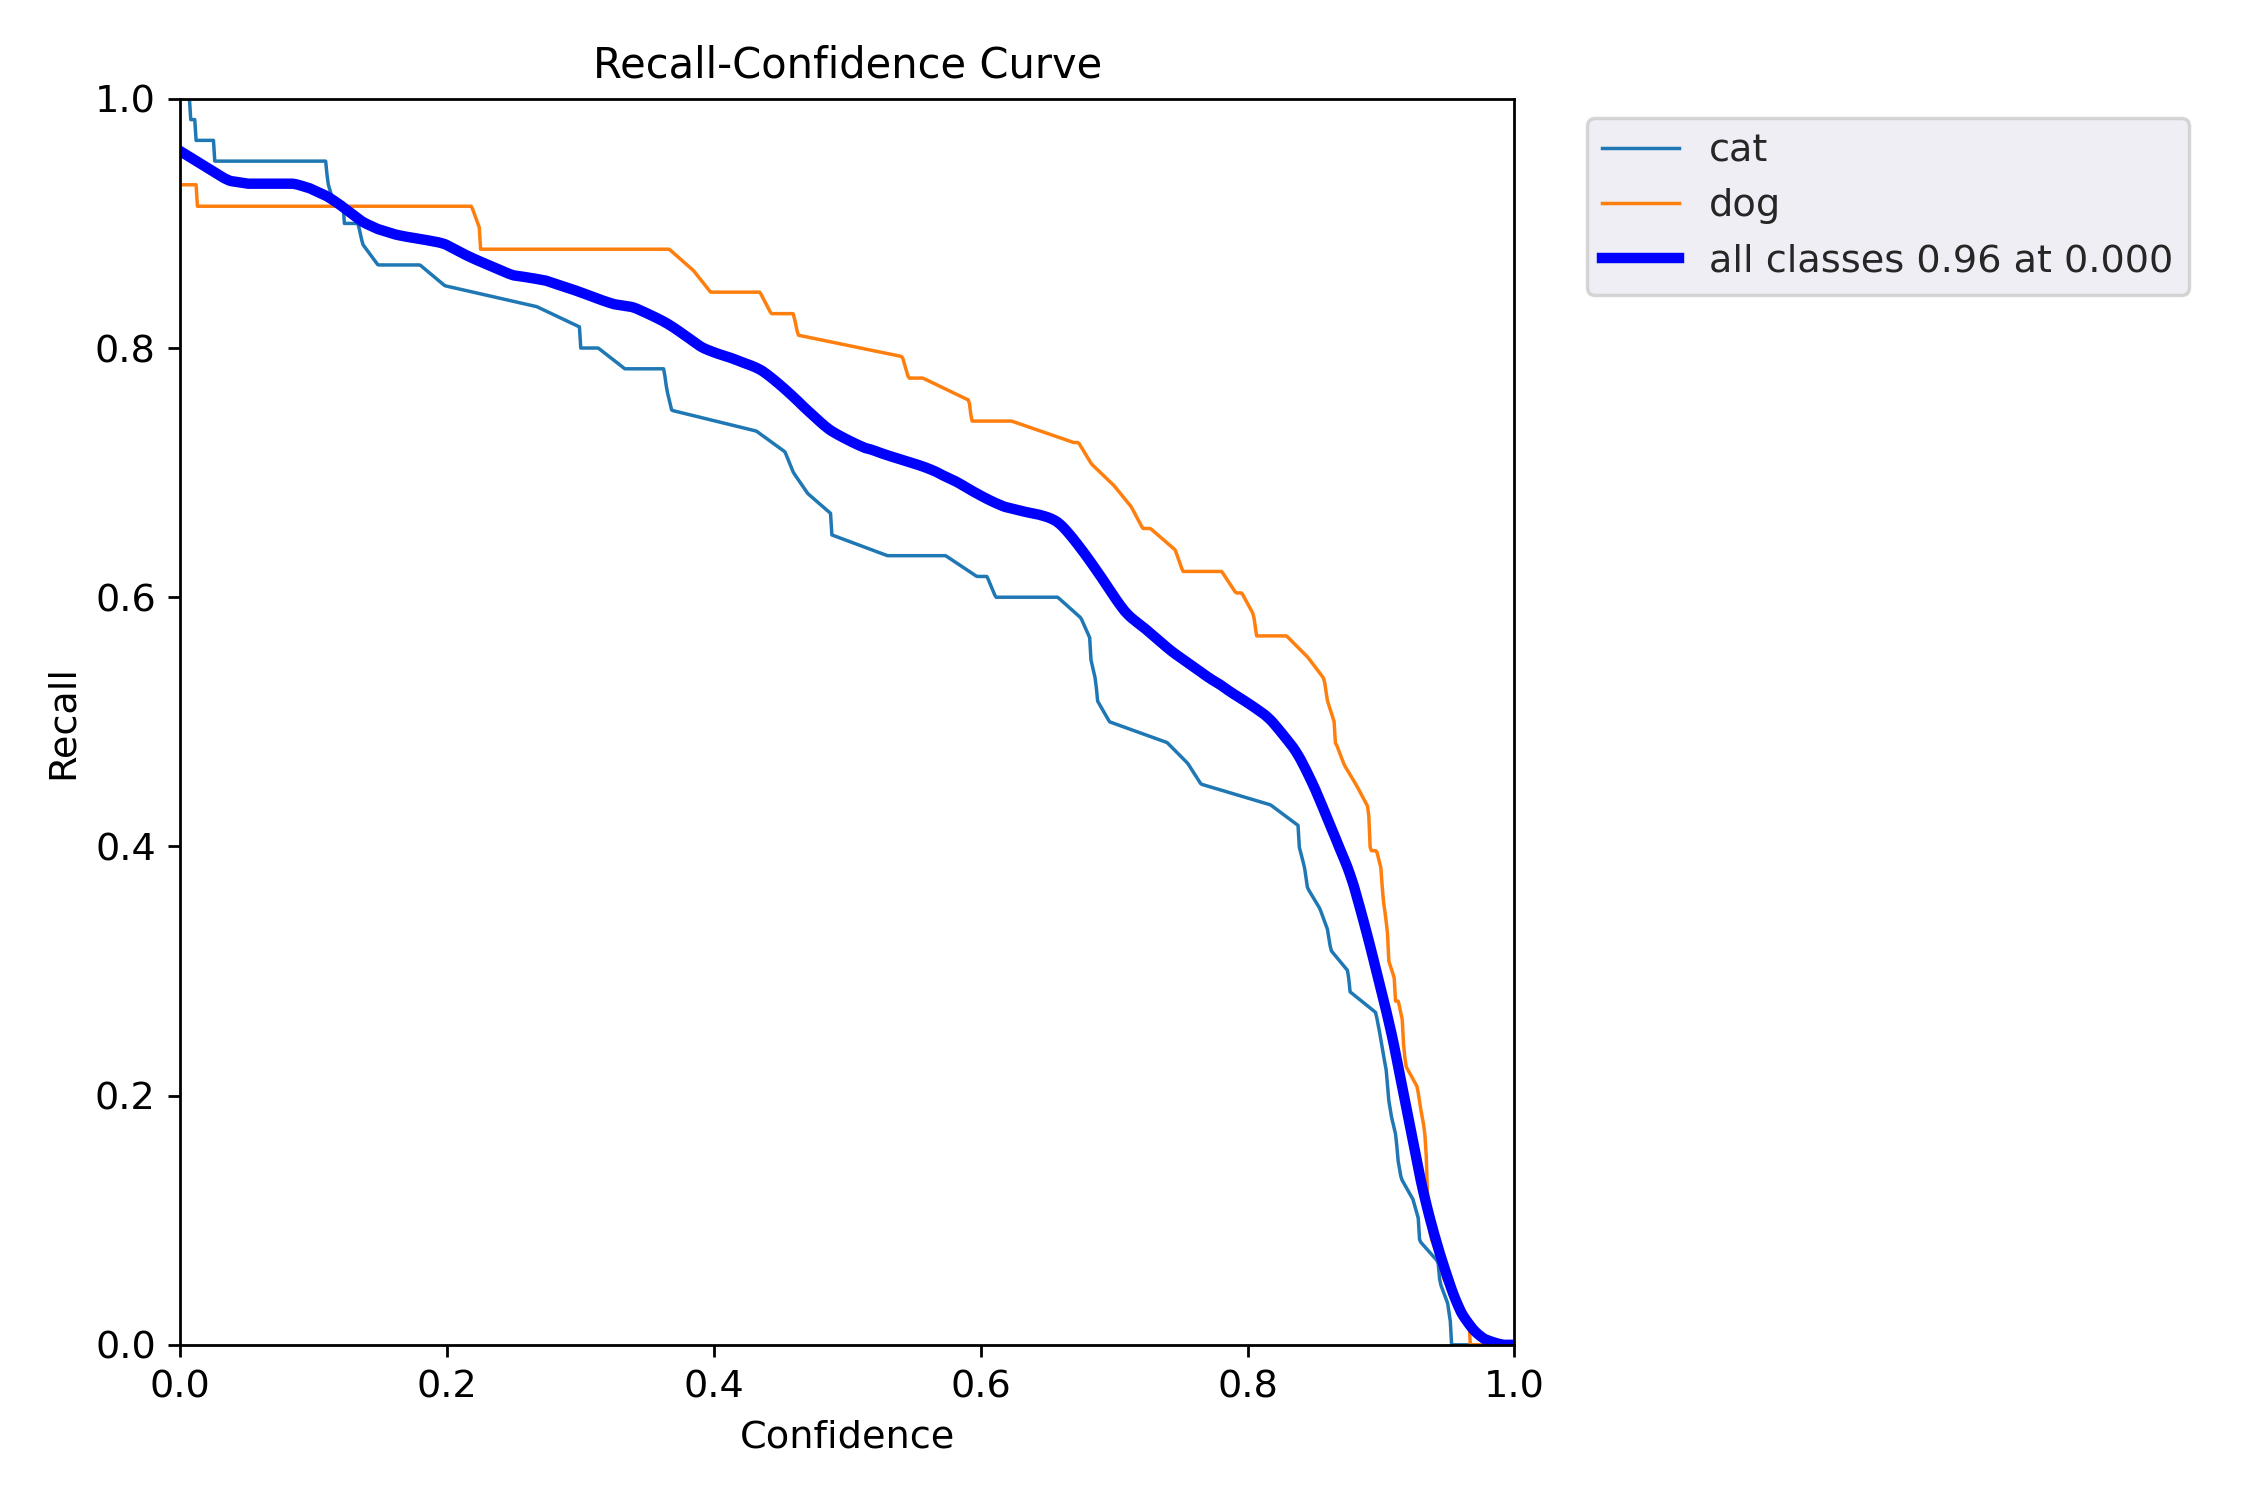

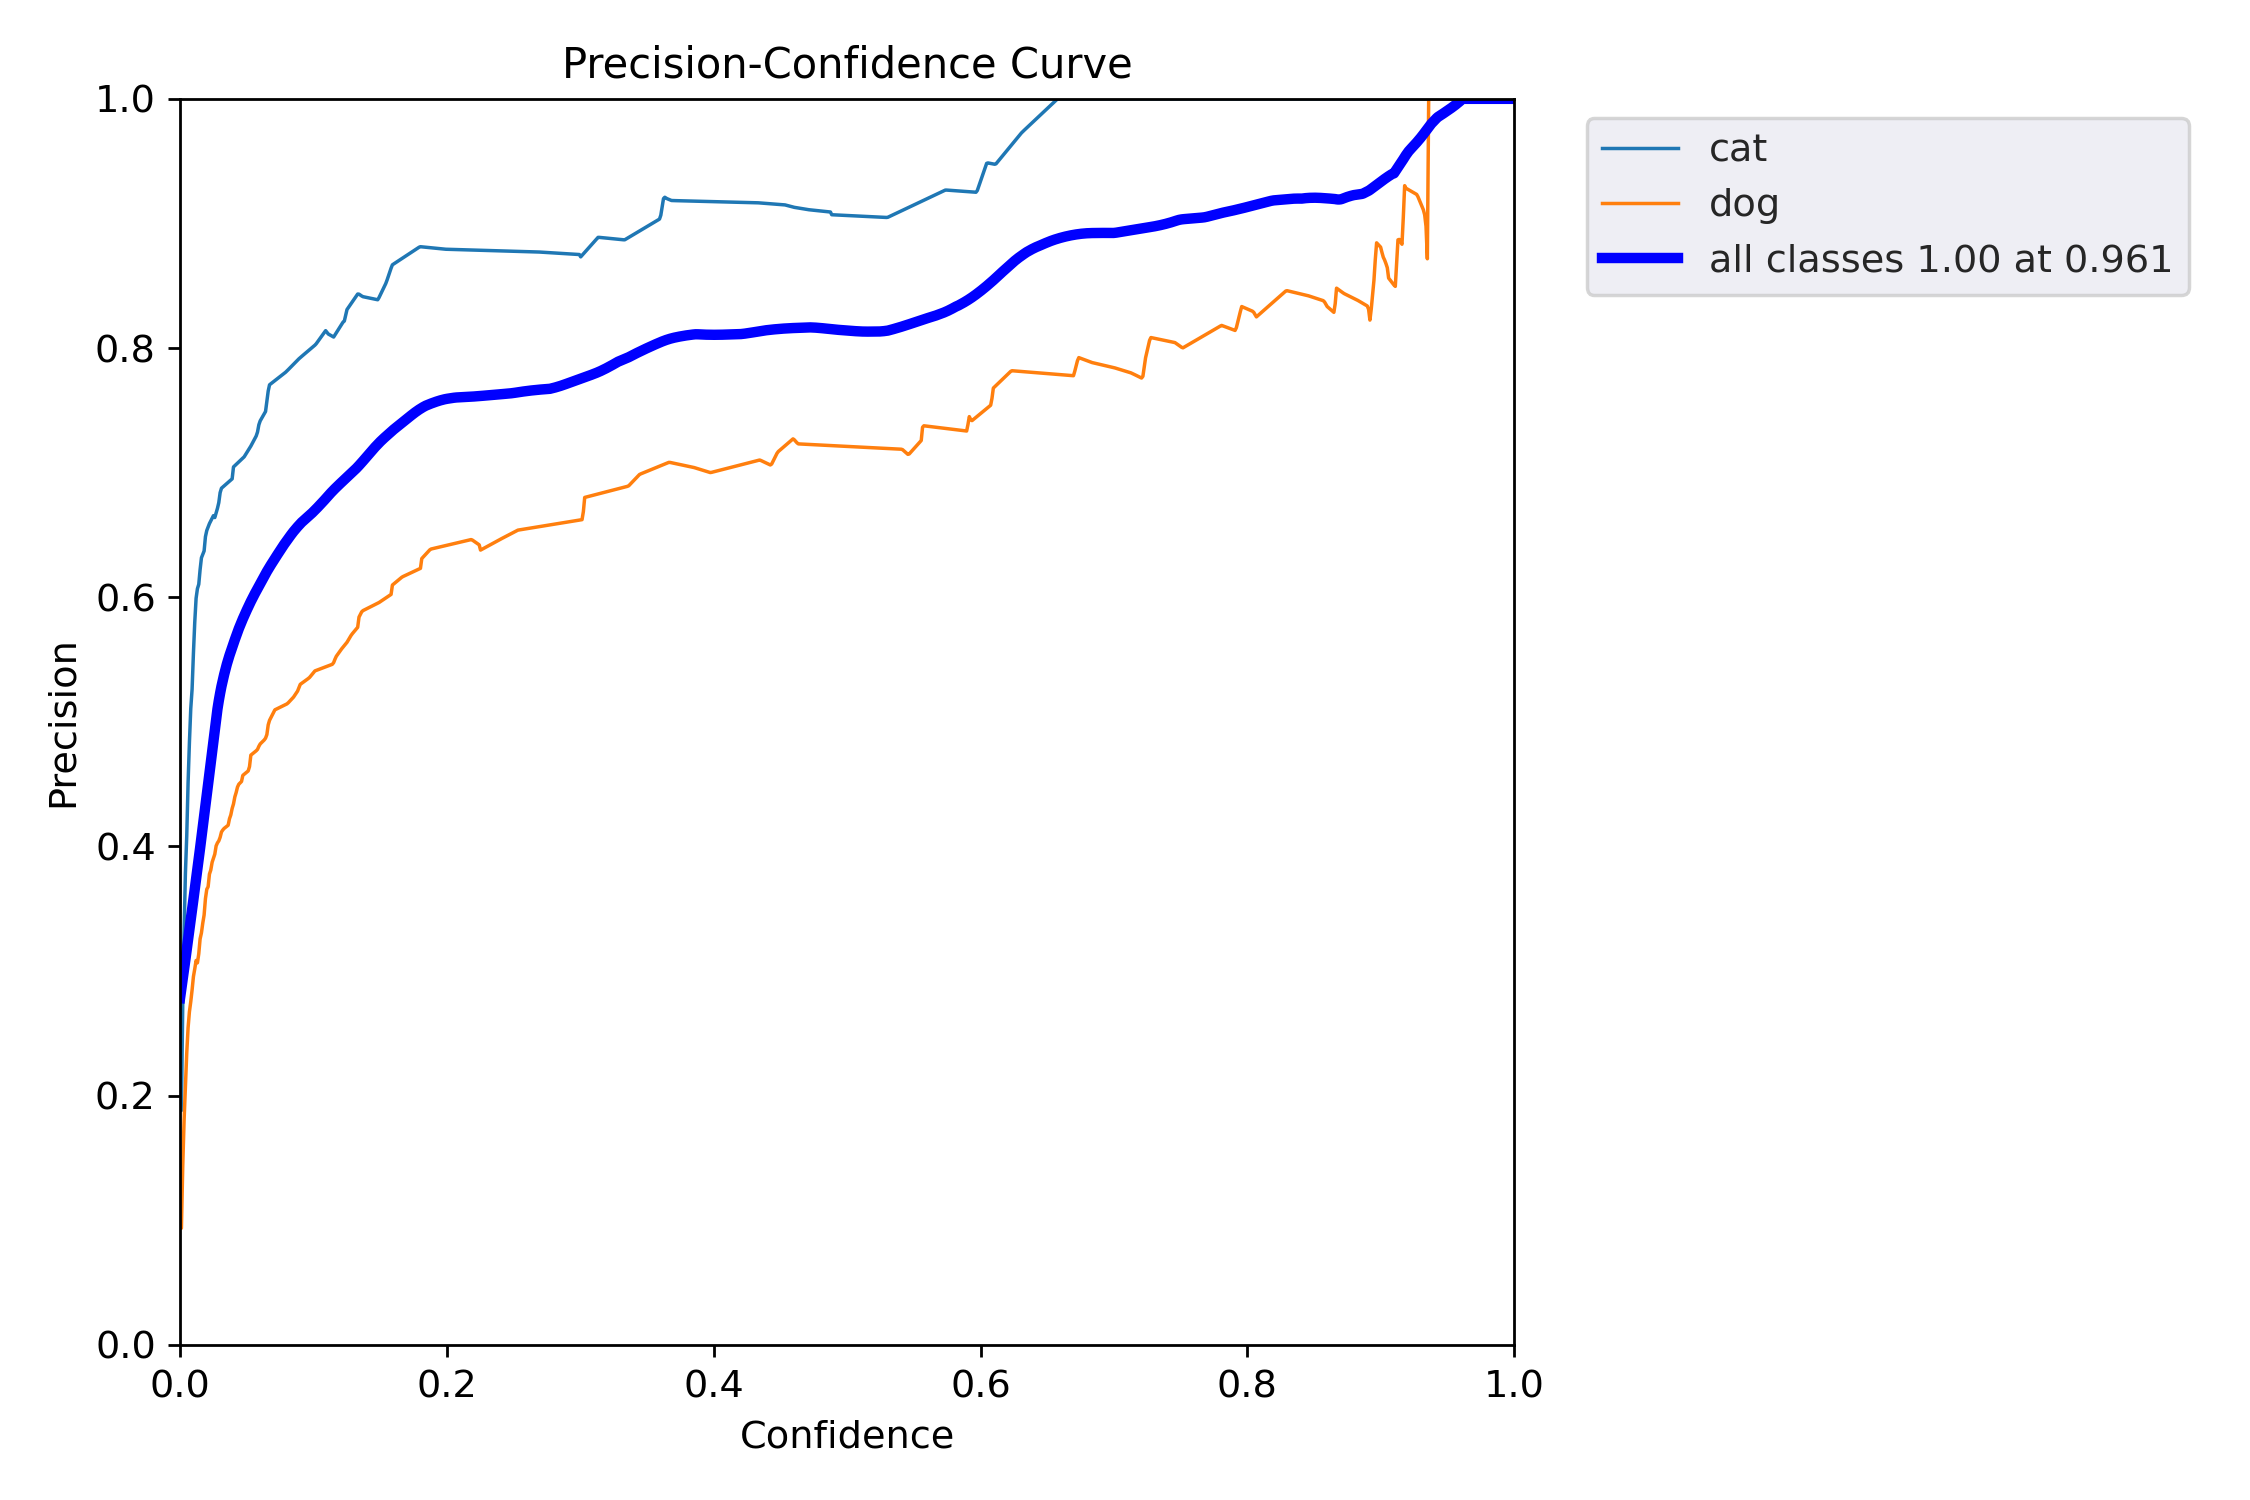

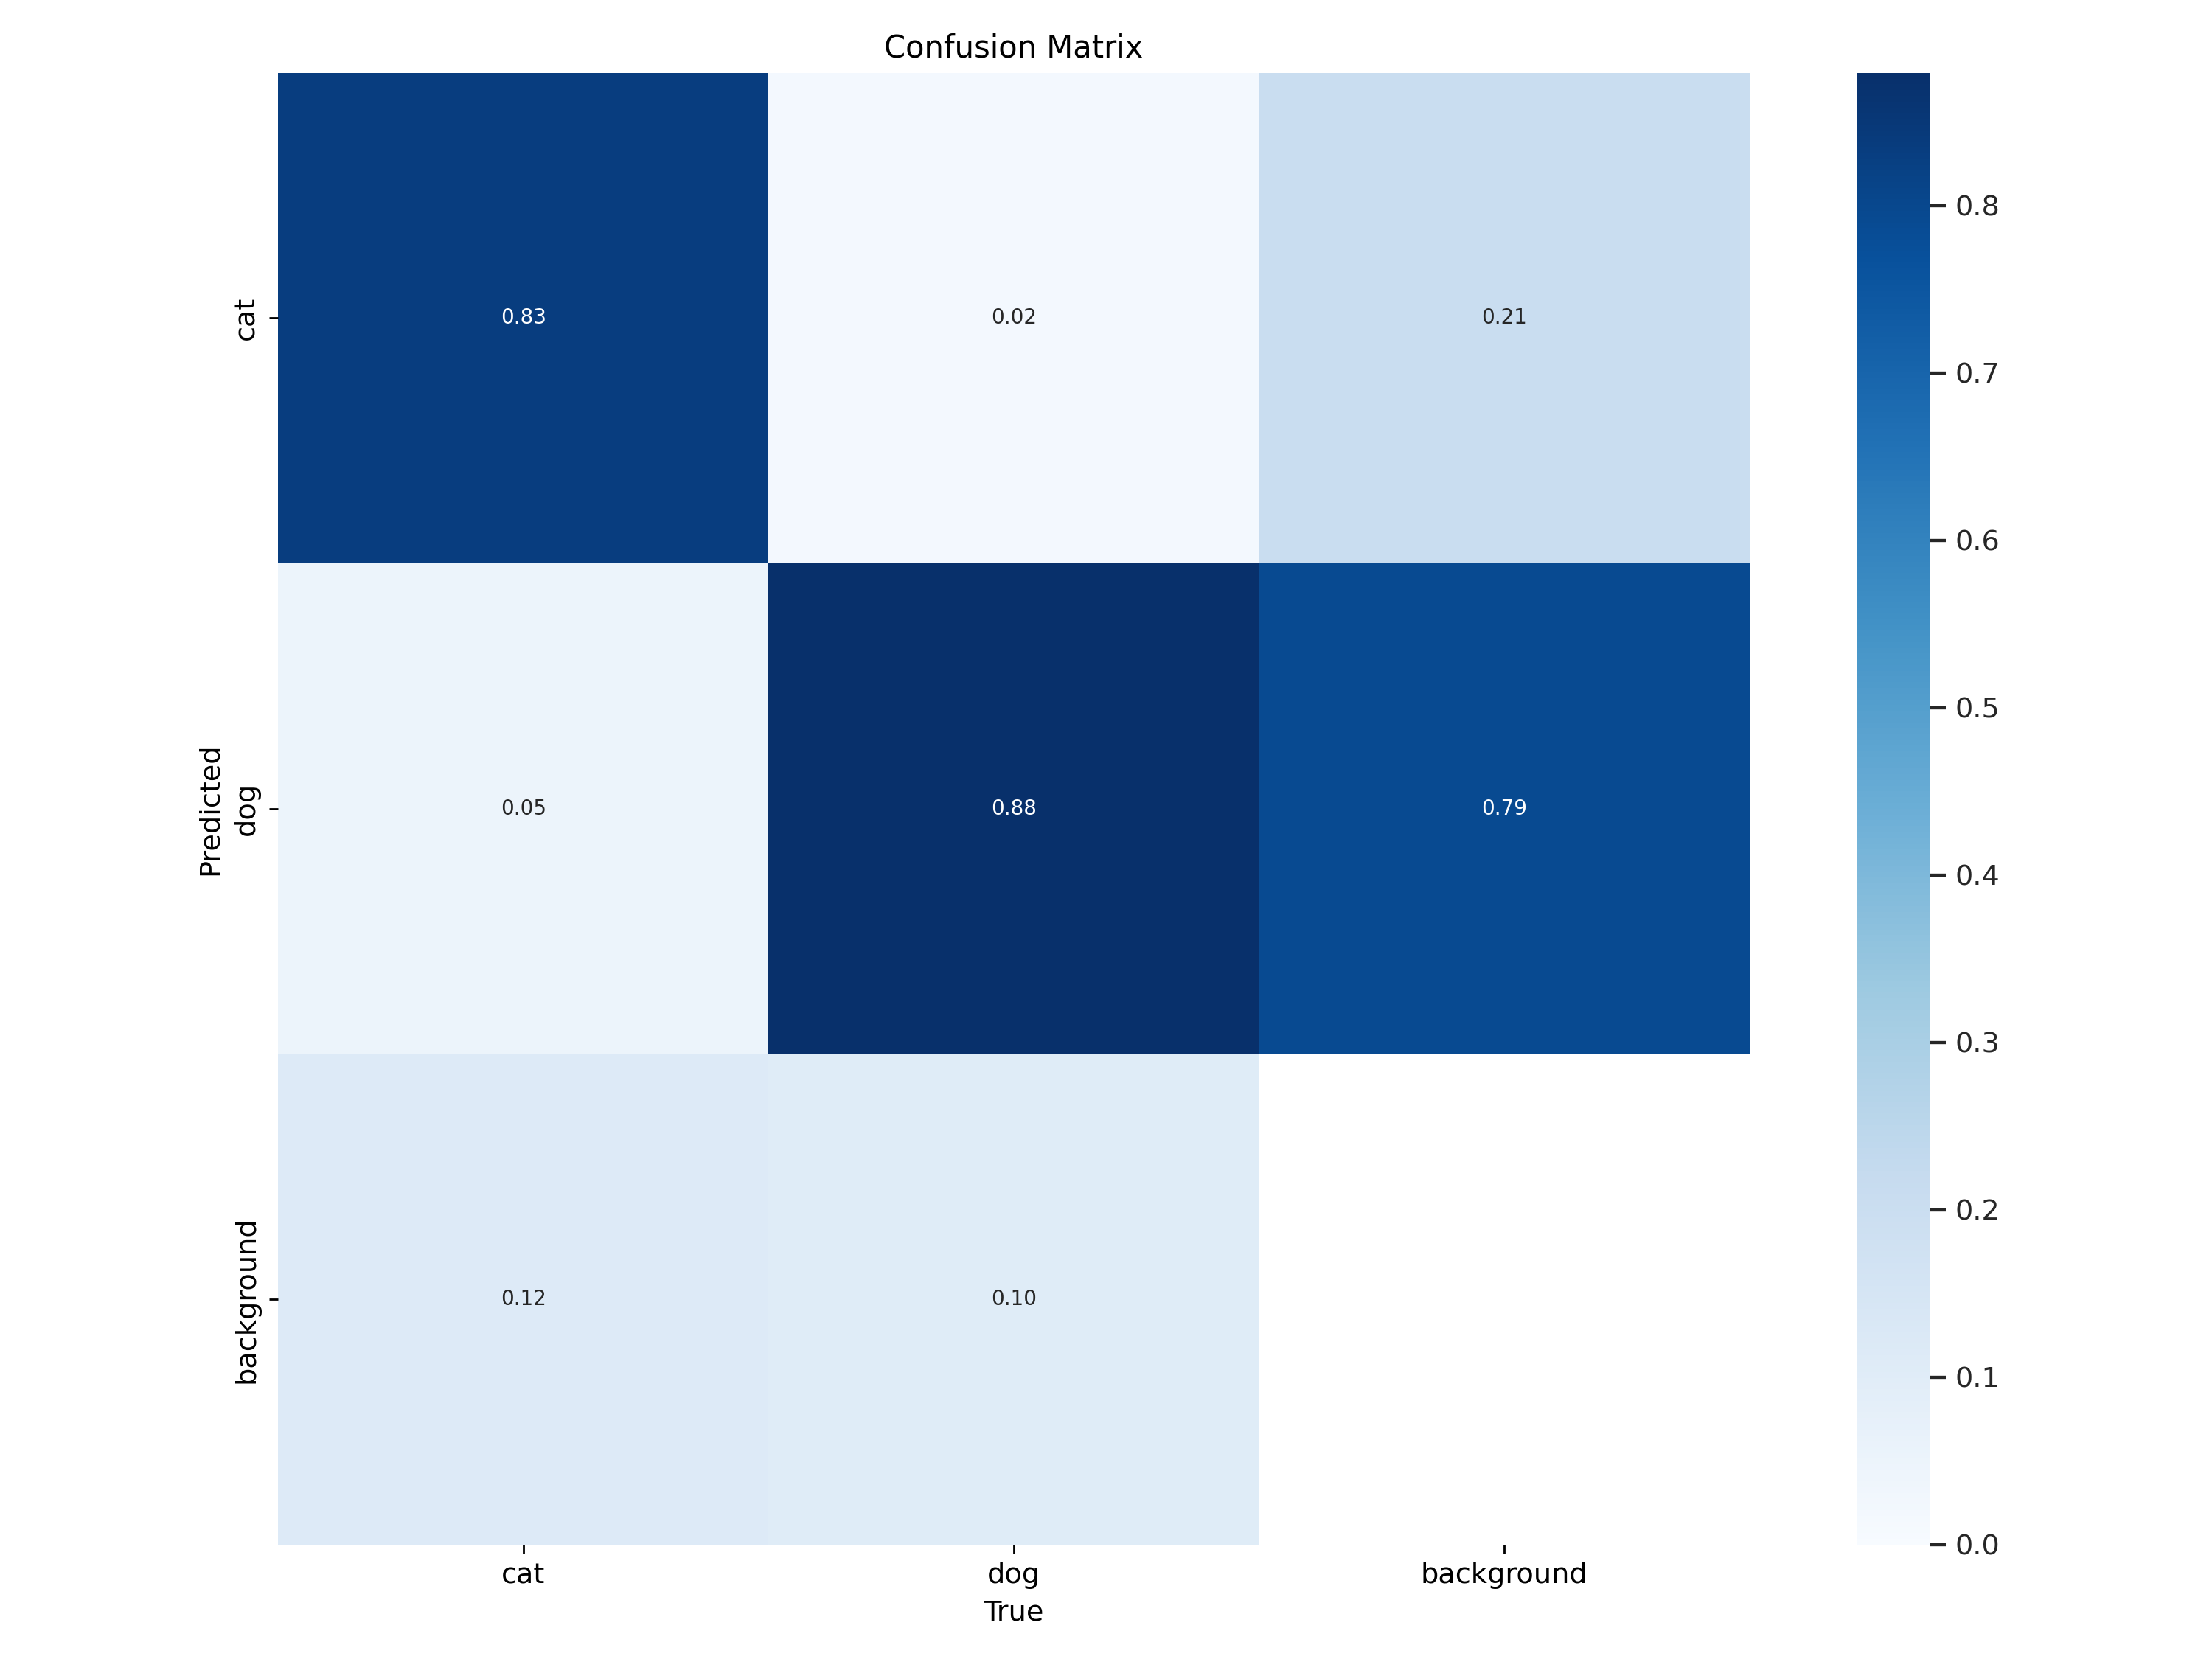

End...


In [37]:
#Metrics values on validation set
show_result_images(val_result_path, '.png')

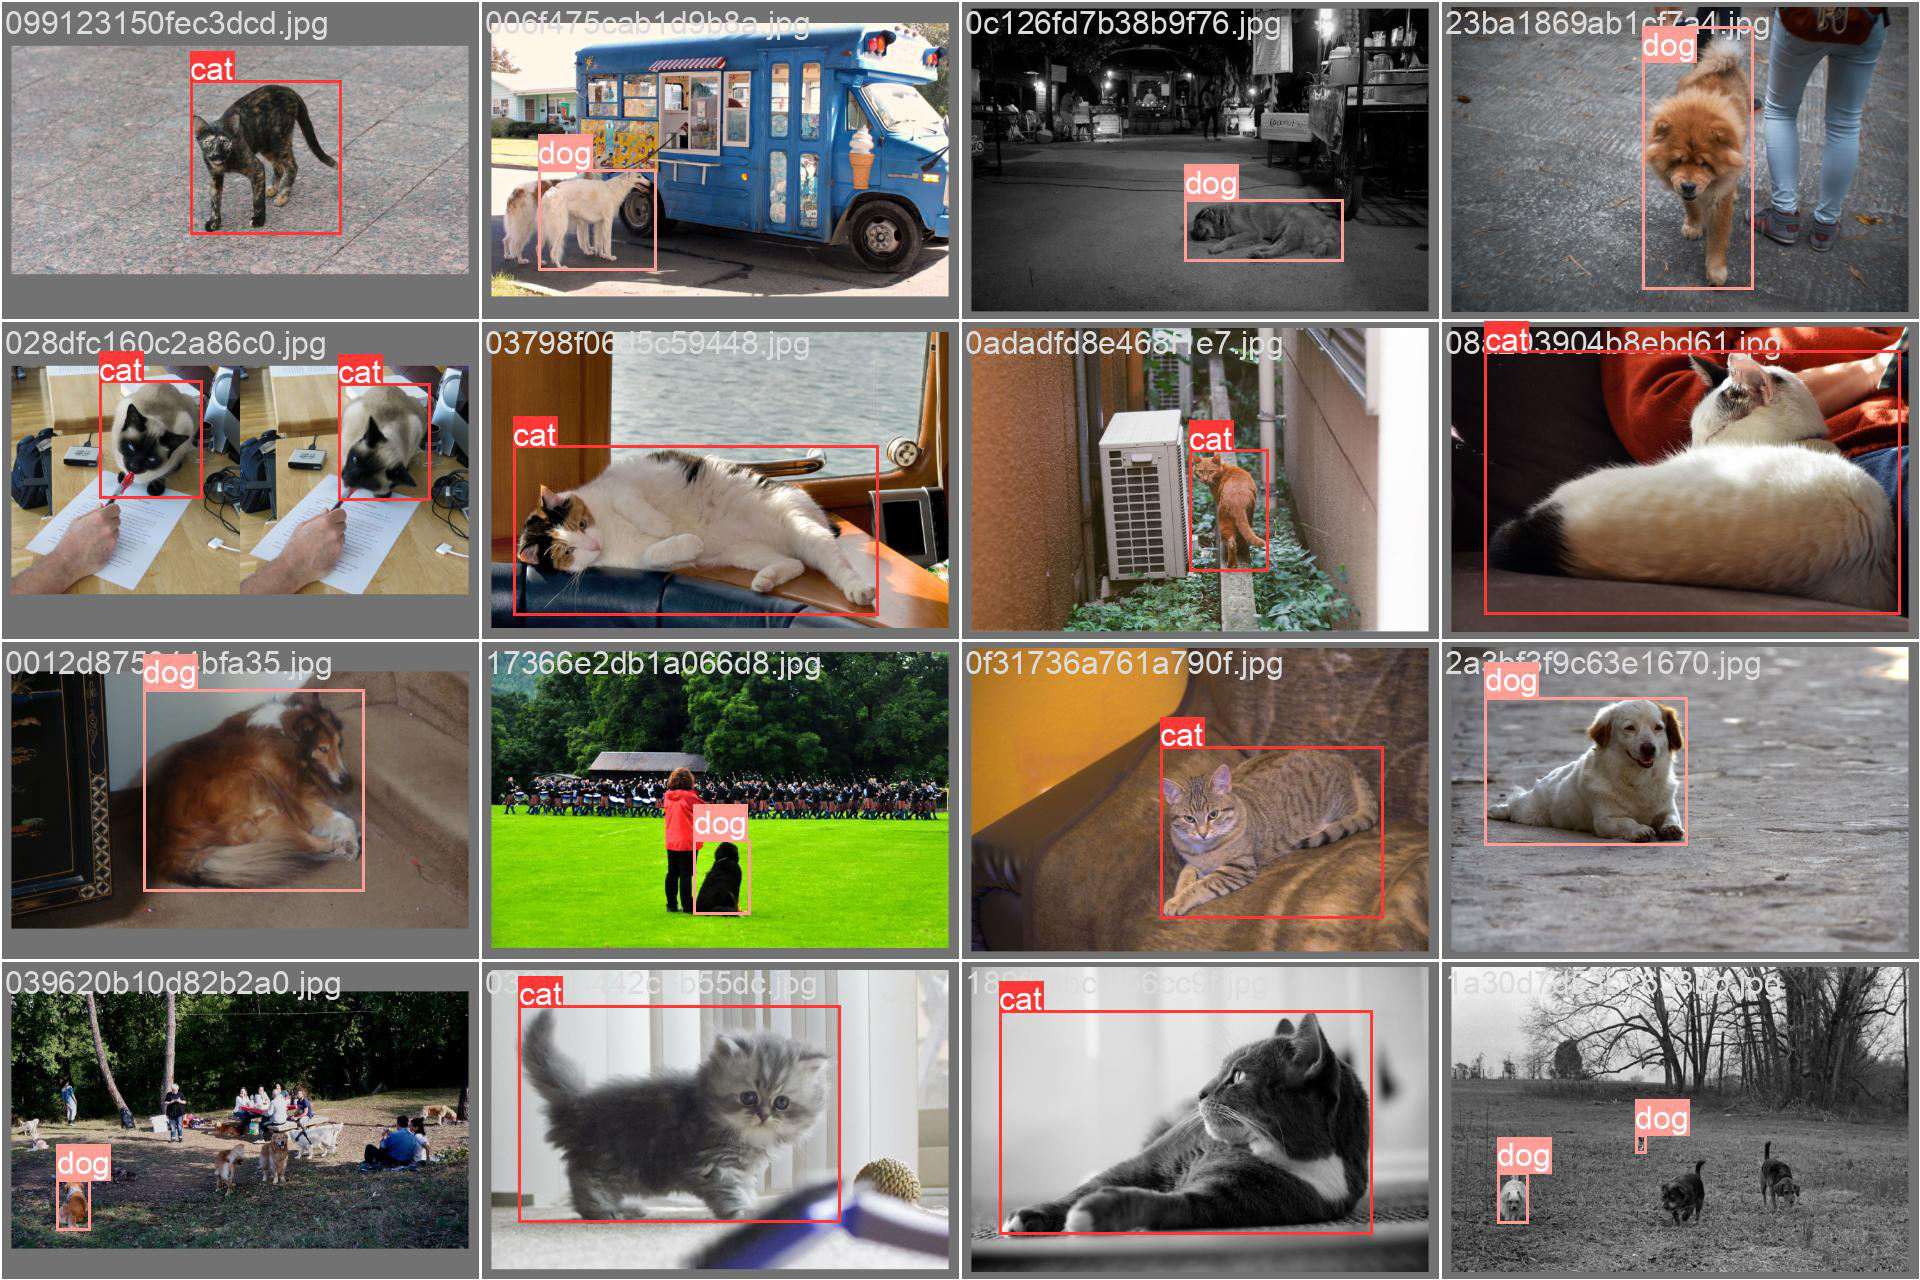

End...


In [43]:
#Prediction on validation examples
show_result_images(val_result_path, '.jpg')

In [39]:
#Test Images
!python yolov5/detect.py --weights run_cat_vs_dogs/feature_extraction2/weights/best.pt --source 'download/cat/images/0013eebbcafa70e5.jpg' --project run_cat_vs_dogs/test --name images

detect: weights=['run_cat_vs_dogs/feature_extraction2/weights/best.pt'], source=download/cat/images/0013eebbcafa70e5.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=run_cat_vs_dogs/test, name=images, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/yolov5-transfer-learning/download/cat/images/0013eebbcafa70e5.jpg: 480x640 1 cat, 517.2ms
Speed: 3.9ms pre-process, 517.2ms inference, 1.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to run_cat_vs_dogs/test/images


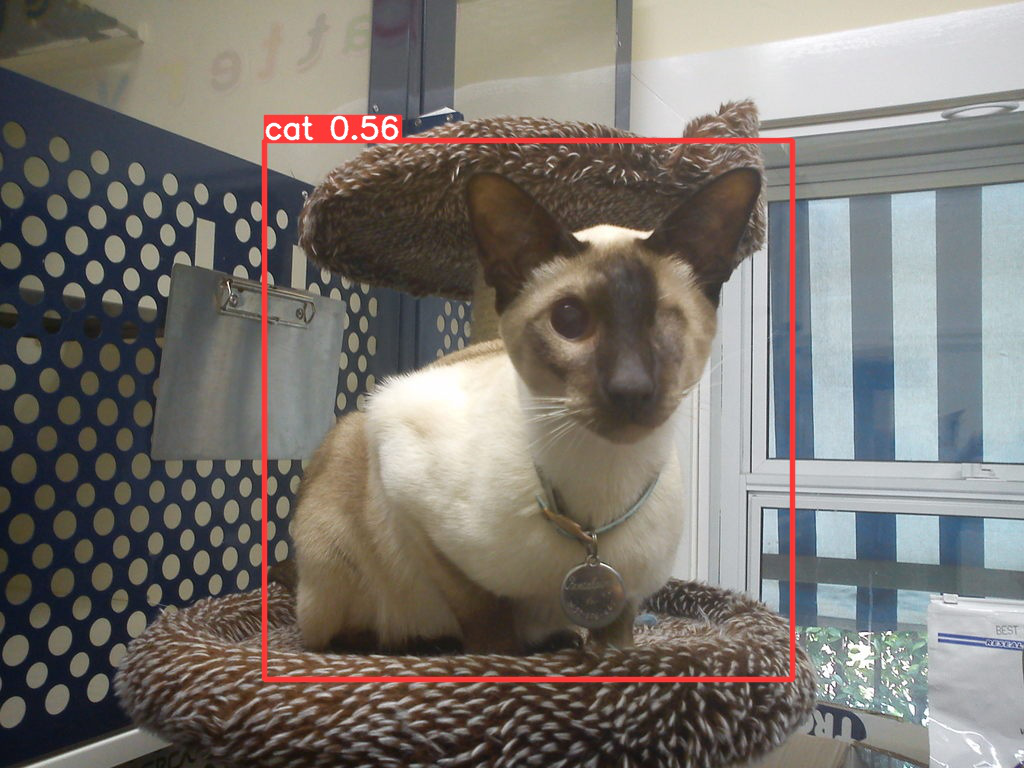

End...


In [40]:
show_result_images('run_cat_vs_dogs/test/images', '.jpg')

In [ ]:
#Test On YouTube video
!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --source 'https://www.youtube.com/watch?v=tSryGsfvLgA' --project run_cat_vs_dogs/test --name videos